In [29]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import linregress
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

Prepare data

In [30]:
df = pd.read_csv('data/DatasetEV3.csv')
df = df[df["100% representative"] ==1]
#df = df[(df['75% form I']==1) | (df['85% IAB, 75%rest']==1)]

df = df.replace("chemo", "chemotroph")
df = df.replace("photo", "phototroph")

df['Rate mean [s-1]'] = df['Rate mean [s-1]'].astype(float)

my_pal = {"chemotroph": '#7e7e7eff', "phototroph": '#ffd343ff'}

Statistical tests

In [31]:
group1 = df[df['energy'] == 'chemotroph']['Rate mean [s-1]'].dropna()
group2 = df[df['energy'] == 'phototroph']['Rate mean [s-1]'].dropna()

# Mann-Whitney U test
statistic, pvalue = mannwhitneyu(group1, group2)

if pvalue < 0.05:
    print(f'Mann-Whitney U test: The two groups are significantly different. p = {pvalue}')
else:
    print('Mann-Whitney U test: The two groups are not significantly different')

Mann-Whitney U test: The two groups are significantly different. p = 4.3990423603014773e-07


Plot

/Users/benoitdepins/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/benoitdepins/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/benoitdepins/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


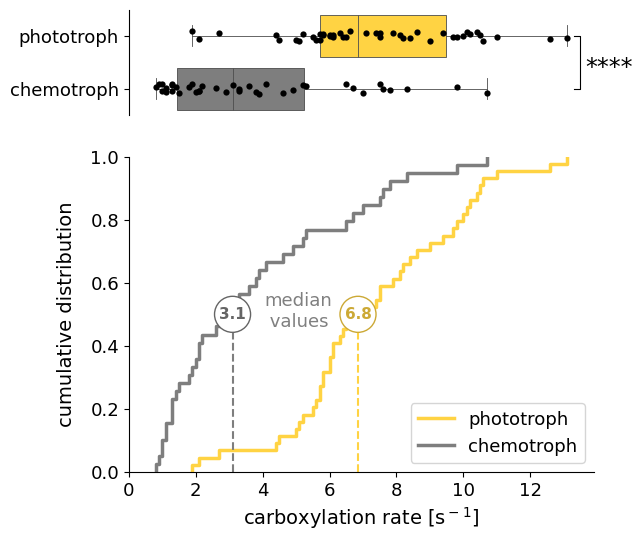

In [32]:
plt.rc('font', size=13)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 6), gridspec_kw={'height_ratios': [1, 3]})

# boxplot/swarmplot on first axis

sns.boxplot(data=df, x='Rate mean [s-1]', y='energy', palette=my_pal, saturation=1, ax=axs[0], order=["phototroph", "chemotroph"], showfliers=False, linewidth=0.6)
sns.stripplot(data=df, x='Rate mean [s-1]', y='energy', color='black', ax=axs[0], order=["phototroph", "chemotroph"], jitter=True, size=4.5)

axs[0].set_ylabel('')
axs[0].spines.top.set_visible(False)
axs[0].spines.right.set_visible(False)
axs[0].spines.bottom.set_visible(False)
axs[0].set_xlabel('')
axs[0].set(xticklabels=[])
axs[0].tick_params(bottom=False)
axs[0].set_xlim(0, 13.9)

# cdf on second axis

sns.ecdfplot(data=df, x='Rate mean [s-1]', hue='energy', hue_order=["phototroph", "chemotroph"], palette=my_pal, ax=axs[1], linewidth=2.5)

axs[1].spines.top.set_visible(False)
axs[1].spines.right.set_visible(False)
axs[1].set_xlabel('carboxylation rate [s$^-$$^1$]', fontsize=14)
axs[1].set_ylabel('cumulative distribution', fontsize=14, labelpad=10)
axs[1].legend_.set_title("")
sns.move_legend(axs[1], "lower right")
axs[1].set_xlim(0, 13.9)

axs[0].set_facecolor('none')
axs[1].set_facecolor('none')

axs[1].text(4.05, 0.46, 'median\n values', fontsize=13, color='grey')

# Find the x-coordinates of the points where the curves cross the y=0.5 line
xcoords = []
xcoords_original = []  # Store the original x-coordinates
for curve in axs[1].get_lines():
    xdata = curve.get_xdata()
    xcoord = np.median([x for x in xdata if x > 0])
    xcoords.append(xcoord)
    xcoords_original.append(xcoord)  # Store the original x-coordinate

# Find the minimum distance between any two markers on the x-axis
min_distance = float('inf')

for i in range(len(xcoords)):
    for j in range(i+1, len(xcoords)):
        distance = abs(xcoords[i] - xcoords[j])
        min_distance = min(min_distance, distance)

# Shift markers that are closer than 1 on the x-axis
for i in range(len(xcoords)):
    for j in range(i+1, len(xcoords)):
        distance = abs(xcoords[i] - xcoords[j])
        if distance < 1:
            if xcoords[i] < xcoords[j]:
                xcoords[i] -= 0.12
                xcoords[j] += 0.12
            else:
                xcoords[i] += 0.12
                xcoords[j] -= 0.12

# Draw vertical lines from the x-axis to the curve at the original x-coordinates
for curve, xcoord, xcoord_original in zip(axs[1].get_lines(), xcoords, xcoords_original):
    ycoord = 0.5
    curve_color = mcolors.to_rgb(curve.get_color())  # Convert color to RGB
    text_color = tuple(np.array(curve_color) * 0.8)  # Darken the color
    axs[1].vlines(xcoord_original, 0, ycoord, color=curve_color, linestyle='dashed')
    # Use the original x-coordinate for the label
    axs[1].annotate(f'{xcoord_original:.1f}', xy=(xcoord, ycoord), xytext=(xcoord, ycoord),
                    color=text_color,
                    ha='center', va='center', fontsize=11, fontweight='bold',
                    bbox=dict(facecolor='white', edgecolor=text_color, boxstyle='circle,pad=0.3'))


# Add stars to box plot to indicate significance level
if pvalue <= 0.0001:
    star = '****'
elif pvalue <= 0.001:
    star = '***'
elif pvalue <= 0.01:
    star = '**'
elif pvalue <= 0.05:
    star = '*'
else:
    star = 'ns'


axs[0].plot([13.3, 13.5, 13.5, 13.3], [0, 0, 1, 1], lw=.8, c = 'black')
axs[0].text(14.35, .81, star, ha='center', va='bottom', fontsize=17)


fig.patch.set_facecolor('none')
plt.savefig(r'plots/photo_chemo_non_homog.svg', dpi=300, bbox_inches='tight')
plt.show()


Summary table

In [33]:
grouped_df = df[df['Rate mean [s-1]'] > 0].groupby('energy')['Rate mean [s-1]']

summary_table = grouped_df.agg(['count', 'median', 'std'])

iqr1 = grouped_df.quantile(0.25)
iqr3 = grouped_df.quantile(0.75)

summary_table = summary_table.round(4)
iqr1 = iqr1.round(4)
iqr3 = iqr3.round(4)

summary_table.columns = ['Number of Samples', 'Median Rate', 'Standard Deviation']
iqr1.name = 'IQR1'
iqr3.name = 'IQR3'

summary_table['IQR1'] = iqr1
summary_table['IQR3'] = iqr3

print(summary_table)

            Number of Samples  Median Rate  Standard Deviation  IQR1   IQR3
energy                                                                     
chemotroph                 39         3.10              2.7145  1.45  5.250
phototroph                 44         6.85              2.5832  5.70  9.475


With homogenous representation of groups - SI

In [34]:
df = df[(df['75% form I']==1) | (df['85% IAB, 75%rest']==1)]

Statistical tests

In [35]:
group1 = df[df['energy'] == 'chemotroph']['Rate mean [s-1]'].dropna()
group2 = df[df['energy'] == 'phototroph']['Rate mean [s-1]'].dropna()

# Mann-Whitney U test
statistic, pvalue = mannwhitneyu(group1, group2)

if pvalue < 0.05:
    print(f'Mann-Whitney U test: The two groups are significantly different. p = {pvalue}')
else:
    print('Mann-Whitney U test: The two groups are not significantly different')

Mann-Whitney U test: The two groups are significantly different. p = 0.0034145826717771614


Plot

/Users/benoitdepins/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/benoitdepins/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/benoitdepins/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


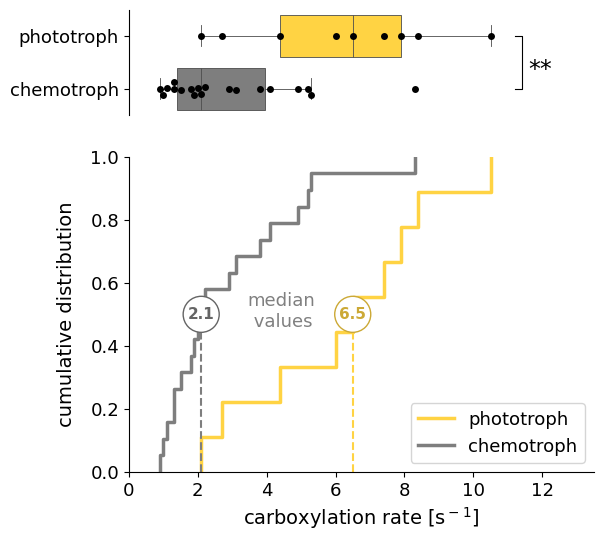

In [36]:
plt.rc('font', size=13)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 6), gridspec_kw={'height_ratios': [1, 3]})

# boxplot/swarmplot on first axis

sns.boxplot(data=df, x='Rate mean [s-1]', y='energy', palette=my_pal, saturation=1, ax=axs[0], order=["phototroph", "chemotroph"], showfliers=False, linewidth=0.6)
sns.swarmplot(data=df, x='Rate mean [s-1]', y='energy', color='black', ax=axs[0], order=["phototroph", "chemotroph"])

axs[0].set_ylabel('')
axs[0].spines.top.set_visible(False)
axs[0].spines.right.set_visible(False)
axs[0].spines.bottom.set_visible(False)
axs[0].set_xlabel('')
axs[0].set(xticklabels=[])
axs[0].tick_params(bottom=False)
axs[0].set_xlim(0, 13.5)

# cdf on second axis

sns.ecdfplot(data=df, x='Rate mean [s-1]', hue='energy', hue_order=["phototroph", "chemotroph"], palette=my_pal, ax=axs[1], linewidth=2.5)

axs[1].spines.top.set_visible(False)
axs[1].spines.right.set_visible(False)
axs[1].set_xlabel('carboxylation rate [s$^-$$^1$]', fontsize=14)
axs[1].set_ylabel('cumulative distribution', fontsize=14, labelpad=10)
axs[1].legend_.set_title("")
sns.move_legend(axs[1], "lower right")
axs[1].set_xlim(0, 13.5)

axs[0].set_facecolor('none')
axs[1].set_facecolor('none')

axs[1].text(3.45, 0.46, 'median\n values', fontsize=13, color='grey')

# Find the x-coordinates of the points where the curves cross the y=0.5 line
xcoords = []
xcoords_original = []  # Store the original x-coordinates
for curve in axs[1].get_lines():
    xdata = curve.get_xdata()
    xcoord = np.median([x for x in xdata if x > 0])
    xcoords.append(xcoord)
    xcoords_original.append(xcoord)  # Store the original x-coordinate

# Find the minimum distance between any two markers on the x-axis
min_distance = float('inf')

for i in range(len(xcoords)):
    for j in range(i+1, len(xcoords)):
        distance = abs(xcoords[i] - xcoords[j])
        min_distance = min(min_distance, distance)

# Shift markers that are closer than 1 on the x-axis
for i in range(len(xcoords)):
    for j in range(i+1, len(xcoords)):
        distance = abs(xcoords[i] - xcoords[j])
        if distance < 1:
            if xcoords[i] < xcoords[j]:
                xcoords[i] -= 0.12
                xcoords[j] += 0.12
            else:
                xcoords[i] += 0.12
                xcoords[j] -= 0.12

# Draw vertical lines from the x-axis to the curve at the original x-coordinates
for curve, xcoord, xcoord_original in zip(axs[1].get_lines(), xcoords, xcoords_original):
    ycoord = 0.5
    curve_color = mcolors.to_rgb(curve.get_color())  # Convert color to RGB
    text_color = tuple(np.array(curve_color) * 0.8)  # Darken the color
    axs[1].vlines(xcoord_original, 0, ycoord, color=curve_color, linestyle='dashed')
    # Use the original x-coordinate for the label
    axs[1].annotate(f'{xcoord_original:.1f}', xy=(xcoord, ycoord), xytext=(xcoord, ycoord),
                    color=text_color,
                    ha='center', va='center', fontsize=11, fontweight='bold',
                    bbox=dict(facecolor='white', edgecolor=text_color, boxstyle='circle,pad=0.3'))


# Add stars to box plot to indicate significance level
if pvalue <= 0.0001:
    star = '****'
elif pvalue <= 0.001:
    star = '***'
elif pvalue <= 0.01:
    star = '**'
elif pvalue <= 0.05:
    star = '*'
else:
    star = 'ns'
    

axs[0].plot([11.2, 11.4, 11.4, 11.2], [0, 0, 1, 1], lw=.8, c = 'black')
axs[0].text(11.95, .85, star, ha='center', va='bottom', fontsize=17)


fig.patch.set_facecolor('none')
plt.savefig(r'plots/photo_chemo_homog.svg', dpi=300, bbox_inches='tight')
plt.show()

Summary table

In [37]:
grouped_df = df[df['Rate mean [s-1]'] > 0].groupby('energy')['Rate mean [s-1]']

summary_table = grouped_df.agg(['count', 'median', 'std'])

iqr1 = grouped_df.quantile(0.25)
iqr3 = grouped_df.quantile(0.75)

summary_table = summary_table.round(4)
iqr1 = iqr1.round(4)
iqr3 = iqr3.round(4)

summary_table.columns = ['Number of Samples', 'Median Rate', 'Standard Deviation']
iqr1.name = 'IQR1'
iqr3.name = 'IQR3'

summary_table['IQR1'] = iqr1
summary_table['IQR3'] = iqr3

print(summary_table)

            Number of Samples  Median Rate  Standard Deviation  IQR1  IQR3
energy                                                                    
chemotroph                 19          2.1              1.9518   1.4  3.95
phototroph                  9          6.5              2.7406   4.4  7.90
